In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.cosmology import Planck15
from scipy.special import sph_harm_y
import pint
from pint.models import get_model
import glob, os #glob2
from astropy import units as u
from astropy.coordinates import SkyCoord
from gwbird import detectors
from gwbird import skymap
from gwbird import utils
from gwbird.overlap import Response
from gwbird.nell import AngularResponse
from gwbird import overlap
from gwbird import nell
from gwbird import skymap
from gwbird import utils
from gwbird import detectors
from gwbird import pls
from gwbird.skymap import Basis, AngularPatternFunction
from gwbird.NANOGrav import NANOGrav_dir
from gwbird.nell import AngularResponse, Sensitivity_ell
import matplotlib.cm as cm


plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# load the pulsar catalog

N, pulsar_xyz, DIST_array = detectors.get_NANOGrav_pulsars()
p = pulsar_xyz
d = DIST_array 

2025-06-04 12:39:07.304 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


In [59]:
f = np.logspace(-9, -7, 100) #Hz

In [60]:
# check the circular polarization in the two frames (for the monopole)

# cosmic rest frame

gamma0_ij_V_crf = []
alpha_ij = []

psi = 0
for i in range(15):
    for j in range(i+1, 15):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V_crf.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))

gamma0_ij_V = np.array(gamma0_ij_V_crf)
alpha_ij = np.array(alpha_ij)

In [61]:
# cosmic rest frame (no pulsar terms)

gamma0_ij_V_crf_noPT = []
alpha_ij_noPT = []

psi = 0
for i in range(15):
    for j in range(i+1, 15):
        alpha_ij_noPT.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_V_crf_noPT.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 'V', psi))

gamma0_ij_V_noPT = np.array(gamma0_ij_V_crf_noPT)
alpha_ij_noPT = np.array(alpha_ij_noPT)

In [62]:
print(gamma0_ij_V_noPT)

[[1.03534123e-03 1.76509673e-03 2.05436615e-03 ... 1.64382024e-03
  1.00667665e-03 2.11680618e-03]
 [3.79280323e-04 3.82009050e-04 5.44073929e-04 ... 3.61133094e-04
  2.87874173e-04 2.82620528e-04]
 [1.40485761e-03 4.54043208e-04 1.46856281e-03 ... 1.31208783e-03
  2.93855852e-04 1.04698989e-03]
 ...
 [5.18181968e-04 1.13189720e-03 1.35741489e-03 ... 3.38151421e-04
  1.15933269e-03 1.95728599e-03]
 [7.48006100e-04 2.80646184e-03 3.57879197e-04 ... 8.44895474e-04
  1.10757089e-03 1.37215817e-03]
 [3.60512156e-05 8.38269179e-05 1.75018741e-04 ... 4.24288369e-04
  5.01511684e-04 3.05108571e-04]]


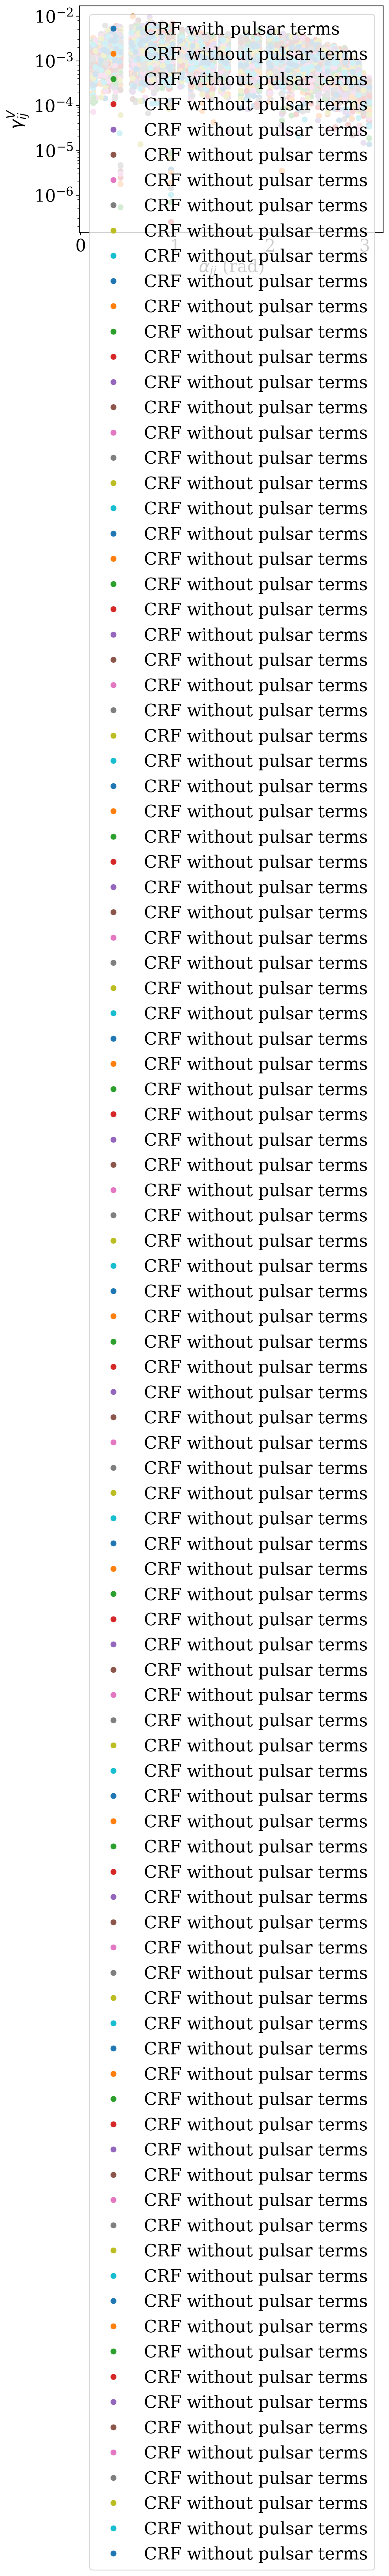

In [63]:
plt.plot(alpha_ij, gamma0_ij_V[:, 0], 'o', label='CRF with pulsar terms')
plt.plot(alpha_ij_noPT, np.abs(gamma0_ij_V_noPT), 'o', label='CRF without pulsar terms')
plt.yscale('log')
plt.xlabel(r'$\alpha_{ij}$ (rad)')
plt.ylabel(r'$\gamma_{ij}^{V}$')
plt.legend()

In [64]:
# computational frame with Pulsar terms

# in this case I just have to rotate easily the pulsars

gamma0_ij_V_comp= []
alpha_ij_comp = []

def rodrigues_rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    I = np.eye(3)
    return I + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K)



for i in range(15):
    for j in range(i+1, 15):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        gamma0_ij_V_comp.append(AngularResponse.R_ell_pairwise(0, pi_rot, pj_rot,  d[i], d[j], f, 'V', psi))
        alpha_ij_comp.append(np.arccos(np.dot(pi_rot, pj_rot)))


gamma0_ij_V_comp = np.array(gamma0_ij_V_comp)
alpha_ij_comp = np.array(alpha_ij_comp)


In [65]:
print(gamma0_ij_V_comp)
print(alpha_ij_comp)

[[2.02872849e-16 2.01403861e-16 1.39327193e-16 ... 4.31706961e-14
  5.58606411e-14 1.12088148e-14]
 [6.39099064e-17 9.43339548e-17 1.10994823e-16 ... 3.04889369e-14
  1.26137916e-14 3.25120884e-15]
 [7.35990583e-16 1.29162774e-15 9.36178912e-16 ... 7.19679089e-14
  1.12730023e-13 7.61698545e-14]
 ...
 [2.99771549e-16 3.88488989e-16 2.40700525e-16 ... 6.01442313e-14
  2.75475161e-15 2.99766947e-14]
 [6.78877777e-16 2.73762229e-16 1.33371245e-15 ... 1.10363831e-13
  4.62298708e-14 4.83771049e-14]
 [2.27115513e-16 1.17815666e-16 4.92662231e-17 ... 6.53173631e-15
  2.10996429e-14 1.00462945e-14]]
[2.00547643 2.86240553 2.11991947 0.31925788 2.47813677 2.60918896
 2.6769977  2.73004177 2.87253831 2.1383636  1.22358809 2.98742648
 0.97192555 2.34535331 1.38645509 1.98800377 1.8859621  1.69152952
 1.50601181 1.55480232 0.7375154  1.29569951 0.75780738 1.76301646
 1.28457575 1.32301259 1.75148313 0.91995962 2.68802071 0.58630566
 0.29128488 0.37624778 0.64894001 0.36341318 1.26537763 1.7664418

In [66]:
# computational frame with no Pulsar terms

# in this case I just have to rotate easily the pulsars

gamma0_ij_V_comp_noPT = []
alpha_ij_comp_noPT = []

def rodrigues_rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    I = np.eye(3)
    return I + np.sin(theta)*K + (1 - np.cos(theta))*(K @ K)



for i in range(15):
    for j in range(i+1, 15):
        # Rotazione per la coppia (i, j)
        p_a = pulsar_xyz[i]
        p_b = pulsar_xyz[j]

        # Step 1: porta p_a su z
        z_hat = np.array([0, 0, 1])
        v = np.cross(p_a, z_hat)
        if np.linalg.norm(v) < 1e-8:
            R1 = np.eye(3)
        else:
            theta = np.arccos(np.clip(np.dot(p_a, z_hat), -1, 1))
            R1 = rodrigues_rotation_matrix(v, theta)

        rotated1 = pulsar_xyz @ R1.T
        p_b_rot1 = p_b @ R1.T

        # Step 2: porta p_b nel piano xz
        phi = np.arctan2(p_b_rot1[1], p_b_rot1[0])
        R2 = np.array([
            [np.cos(-phi), -np.sin(-phi), 0],
            [np.sin(-phi),  np.cos(-phi), 0],
            [0,             0,            1]
        ])

        rotated_coords = rotated1 @ R2.T  # shape (N, 3)

        # Coord. di i e j nel frame ruotato
        pi_rot = rotated_coords[i]
        pj_rot = rotated_coords[j]

        # Calcola angolo tra le due pulsar nel frame originale
        gamma0_ij_V_comp_noPT.append(AngularResponse.R_ell_pairwise(0, pi_rot, pj_rot,  d[i], d[j], f, 'V', psi))
        alpha_ij_comp_noPT.append(np.arccos(np.dot(pi_rot, pj_rot)))


gamma0_ij_V_comp_noPT = np.array(gamma0_ij_V_comp_noPT)
alpha_ij_comp_noPT = np.array(alpha_ij_comp_noPT)


In [67]:
print(alpha_ij_comp_noPT)

[2.00547643 2.86240553 2.11991947 0.31925788 2.47813677 2.60918896
 2.6769977  2.73004177 2.87253831 2.1383636  1.22358809 2.98742648
 0.97192555 2.34535331 1.38645509 1.98800377 1.8859621  1.69152952
 1.50601181 1.55480232 0.7375154  1.29569951 0.75780738 1.76301646
 1.28457575 1.32301259 1.75148313 0.91995962 2.68802071 0.58630566
 0.29128488 0.37624778 0.64894001 0.36341318 1.26537763 1.76644182
 0.13162469 2.20335002 0.74097231 2.36536112 0.35822395 1.06820791
 0.56518537 1.40440098 0.77247021 1.34741091 2.23104834 0.93233424
 2.93380717 0.24425128 2.70243549 2.39706573 2.82343493 2.50756151
 3.04906517 2.27291272 0.93045871 2.79378745 0.68236665 2.60800162
 0.79139981 0.21348049 1.05180679 0.4198287  1.18168468 2.19102478
 0.57964152 2.78703308 0.15586834 0.60787127 0.80253064 0.65364132
 1.53561825 1.48337273 0.41192846 2.00005782 0.94476998 0.86820951
 0.26009703 1.16634453 2.06860027 0.36755602 2.5794824  0.36568516
 0.63253316 0.859847   1.82442301 0.55151967 1.82761638 1.1652

In [68]:
print(gamma0_ij_V_comp_noPT)

[[2.02872849e-16 2.01403861e-16 1.39327193e-16 ... 4.31706961e-14
  5.58606411e-14 1.12088148e-14]
 [6.39099064e-17 9.43339548e-17 1.10994823e-16 ... 3.04889369e-14
  1.26137916e-14 3.25120884e-15]
 [7.35990583e-16 1.29162774e-15 9.36178912e-16 ... 7.19679089e-14
  1.12730023e-13 7.61698545e-14]
 ...
 [2.99771549e-16 3.88488989e-16 2.40700525e-16 ... 6.01442313e-14
  2.75475161e-15 2.99766947e-14]
 [6.78877777e-16 2.73762229e-16 1.33371245e-15 ... 1.10363831e-13
  4.62298708e-14 4.83771049e-14]
 [2.27115513e-16 1.17815666e-16 4.92662231e-17 ... 6.53173631e-15
  2.10996429e-14 1.00462945e-14]]


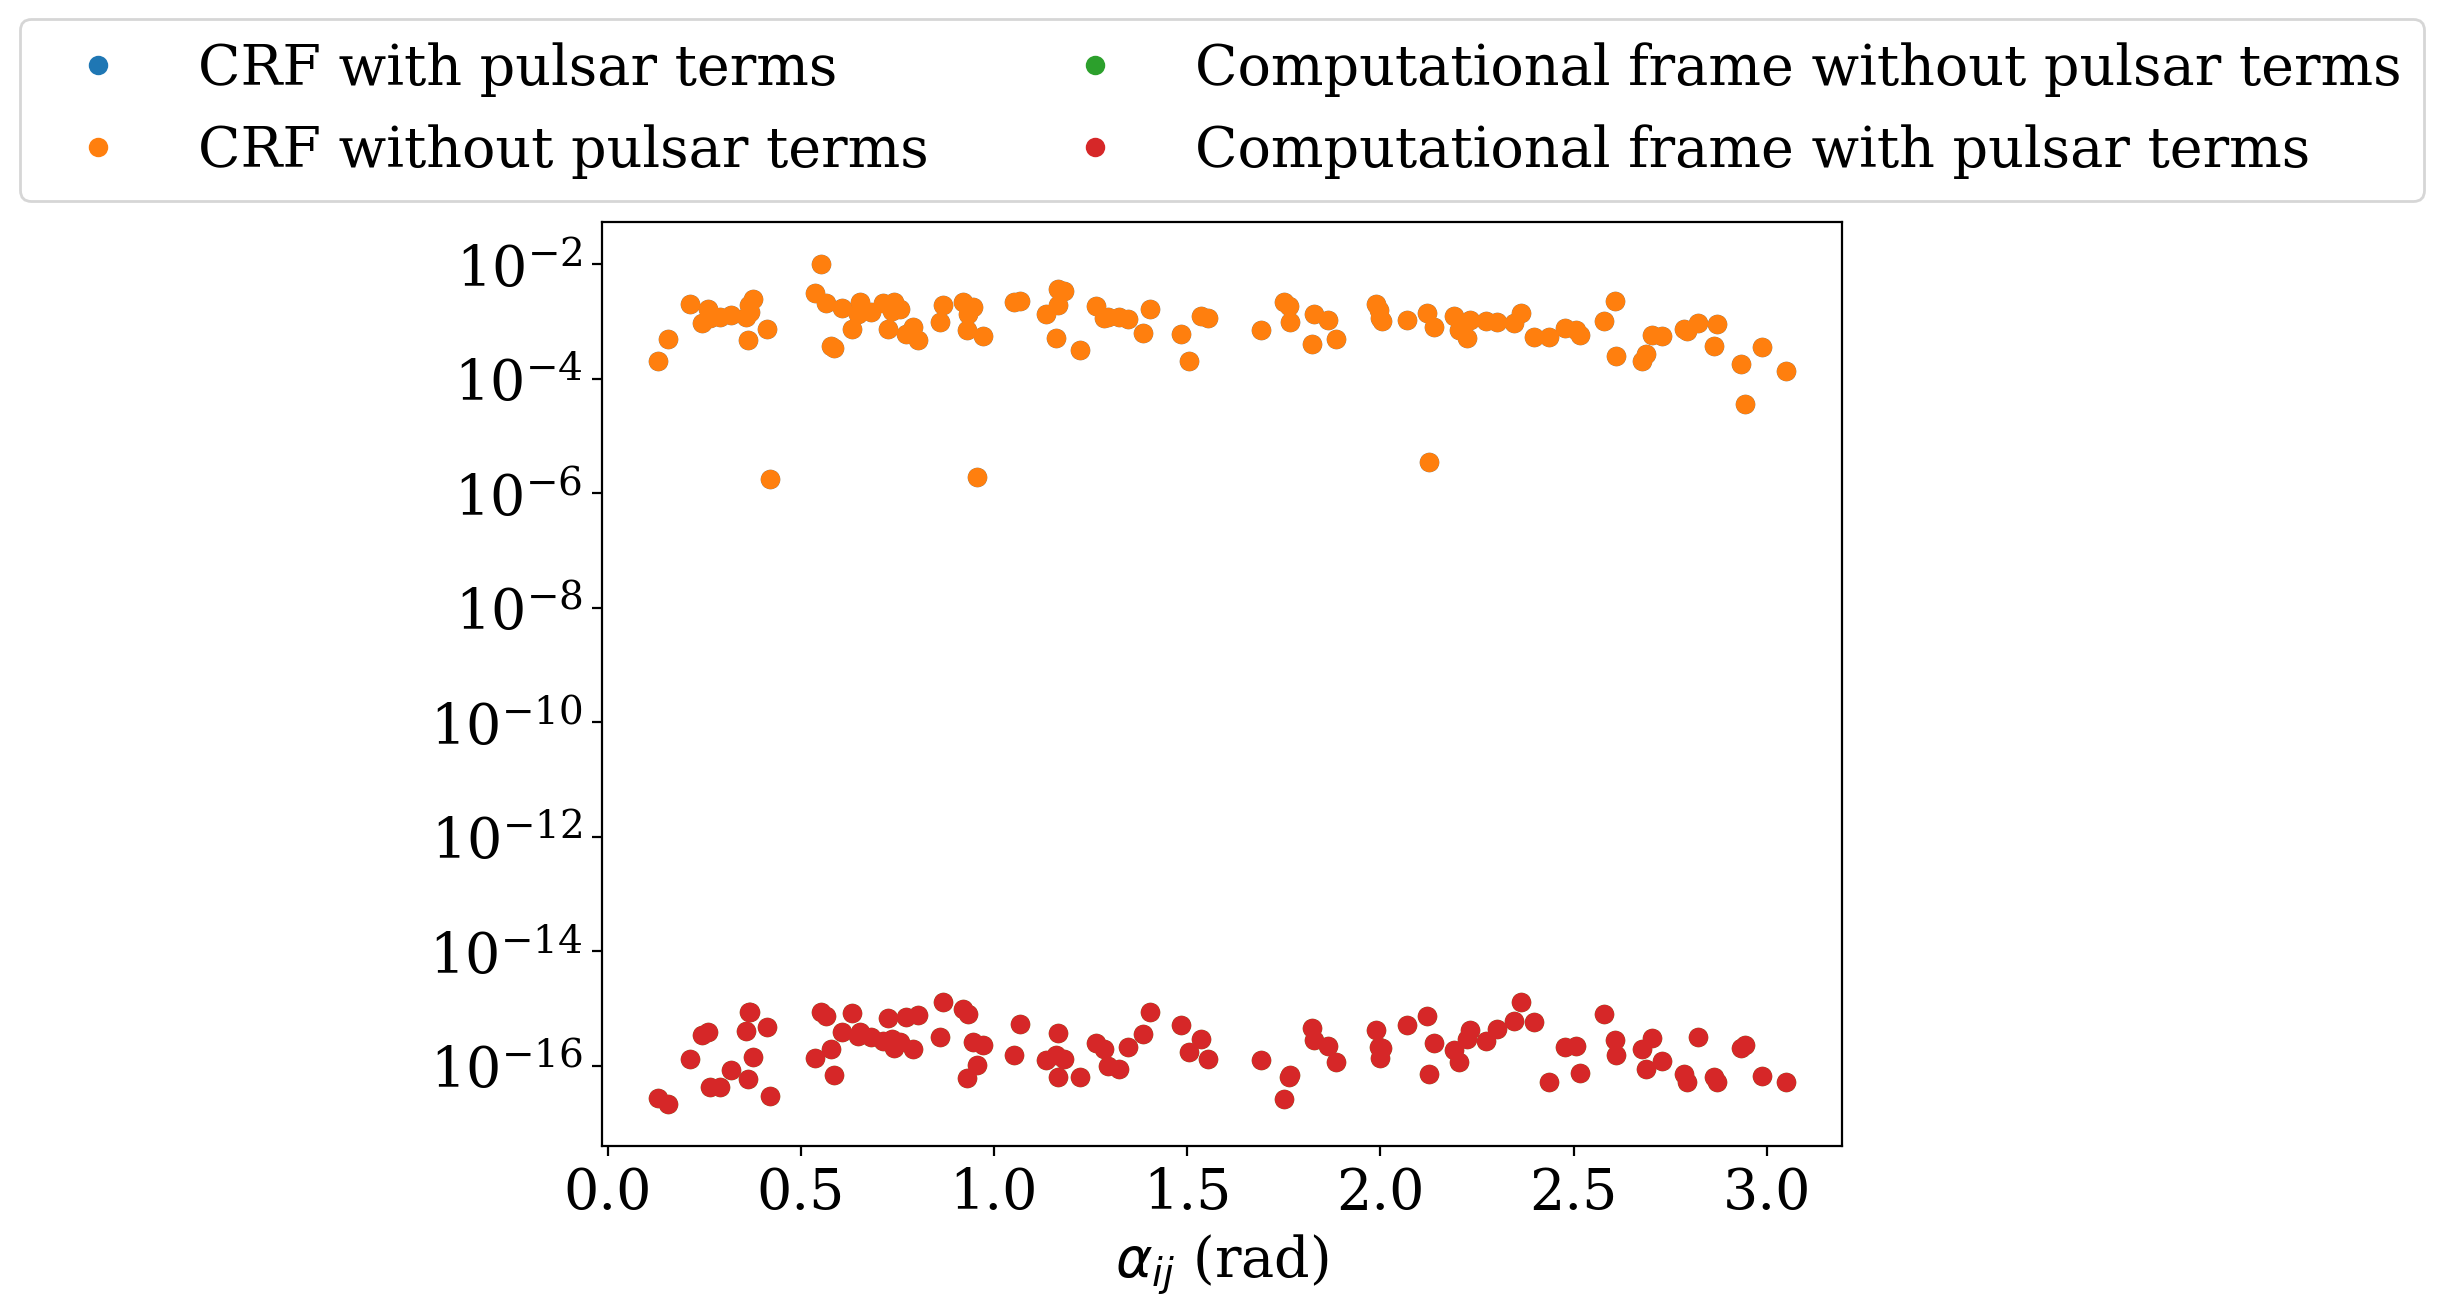

In [75]:
# plot

plt.figure(figsize=(8, 6))
plt.plot(alpha_ij, gamma0_ij_V[:, 0], 'o', label='CRF with pulsar terms')
plt.plot(alpha_ij_noPT, np.abs(gamma0_ij_V_noPT[:, 0]), 'o', label='CRF without pulsar terms')
plt.plot(alpha_ij_comp_noPT, np.abs(gamma0_ij_V_comp_noPT[:,0]), 'o', label='Computational frame without pulsar terms')
plt.plot(alpha_ij_comp, np.abs(gamma0_ij_V_comp[:, 0]), 'o', label='Computational frame with pulsar terms')

plt.yscale('log')
plt.xlabel(r'$\alpha_{ij}$ (rad)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)


In [70]:
# now an easier computaitional frame

import numpy as np

def gamma0_V_fictitious(xi, f, psi=0):
    """
    Computes the angular response gamma0 for a fictitious configuration
    with one pulsar at the North Pole and the other at angle xi.

    Parameters:
    xi : float or array-like
        Angular separation between the two pulsars in radians.
    f : float
        Frequency [Hz].
    psi : float
        Polarization angle (default: 0).

    Returns:
    gamma0 : float or ndarray
        Angular response.
    """
    d_i = d_j = 5 * 3.086e+19  # convert kpc to meters
    p_i = np.array([0, 0, 1])
    if np.isscalar(xi):
        p_j = np.array([np.sin(xi), 0, np.cos(xi)])
        return AngularResponse.R_ell_pairwise(0, p_i, p_j, d_i, d_j, f, 'V', psi)
    else:
        # Vectorized version if xi is an array
        gamma0_vals = []
        for angle in xi:
            p_j = np.array([np.sin(angle), 0, np.cos(angle)])
            gamma0 = AngularResponse.R_ell_pairwise(0, p_i, p_j, d_i, d_j, f, 'V', psi)
            gamma0_vals.append(gamma0)
        return np.array(gamma0_vals)



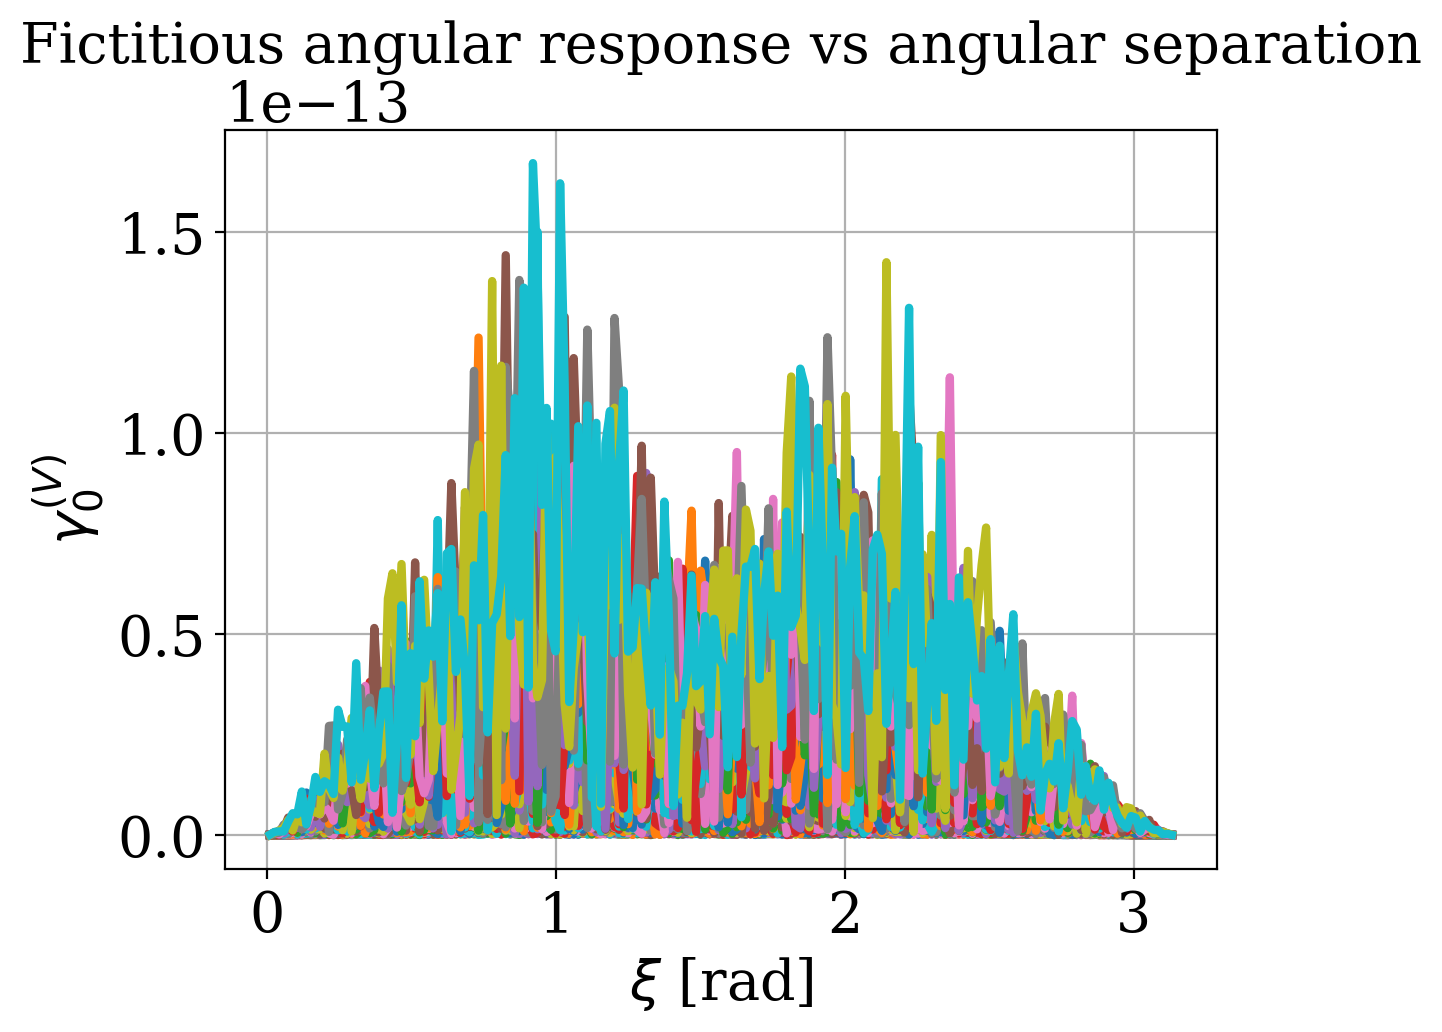

In [71]:
import matplotlib.pyplot as plt

xi_vals = np.linspace(0.01, np.pi- 0.01, 200)
f = np.logspace(-9, -7, 100)  # Frequency range in Hz

gamma_vals = gamma0_V_fictitious(xi_vals, f)

plt.plot(xi_vals, gamma_vals)
plt.xlabel(r"$\xi$ [rad]")
plt.ylabel(r"$\gamma_0^{(V)}$")
plt.title("Fictitious angular response vs angular separation")
plt.grid(True)
plt.show()


In [72]:
print(gamma_vals)

[[2.30504544e-18 1.24683250e-18 2.49366500e-18 ... 1.52930560e-16
  8.56914879e-17 1.38823991e-16]
 [7.37257477e-18 3.78229643e-18 7.05981306e-18 ... 4.07965126e-16
  6.40120161e-16 8.12605154e-16]
 [4.33680869e-18 2.41034505e-17 3.19867204e-17 ... 6.04272667e-16
  1.12467297e-15 9.18311329e-16]
 ...
 [4.67088591e-18 6.13317367e-18 1.35832836e-17 ... 2.27899297e-16
  8.09409142e-16 2.32883084e-16]
 [4.83048267e-18 9.95165308e-19 1.93947981e-18 ... 4.03759433e-16
  4.88998477e-16 3.24073089e-16]
 [8.74111737e-19 6.22974162e-19 5.76261359e-19 ... 5.50074807e-17
  1.44565513e-16 4.95891710e-17]]


In [73]:
xi = np.pi / 3  # 60 gradi
p_i = np.array([0, 0, 1])
p_j = np.array([np.sin(xi), 0, np.cos(xi)])
print("p_j =", p_j)
print("dot =", np.dot(p_i, p_j))  # = cos(xi)
gamma_ij =  AngularResponse.R_ell_pairwise(0, p_i, p_j, 1, 1, f, 'V', -np.pi/ 2)

print("gamma =", AngularResponse.R_ell_pairwise(0, p_i, p_j, 1, 1, f, 'V', 0))

p_j = [0.8660254 0.        0.5      ]
dot = 0.5000000000000001
gamma = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.34552942e-51 0.00000000e+00
 0.00000000e+00 1.06910588e-50 1.06910588e-50 1.06910588e-50
 1.06910588e-50 0.00000000e+00 0.00000000e+00 2.13821177e-50
 2.13821177e-50 4.27642354e-50 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.27642354e-50
 4.27642354e-50 0.00000000e+00 4.27642354e-50 0.00000000e+00
 8.55284707e-50 8.55284707e-50 8.55284707e-50 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.55284707e-50 0.00000000e+00 1.71056941e-49 0.00000000e+00
 1.71056941e-49 1.71056941e-49 1.71056941e-49 1.71056941e-49
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.42113883e-49
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.42113883e-49
 1.36845553e-48 0.00000000e+00 6.84227766e-49 6.84227766e-49
 0.00000000e+00 6.84227766e-49 0.00000000e+00 0.00000000e+00
 0.00000000e+0